### Requeriments:
numpy==1.21.6<br>
sklearn==0.0<br>
keras==2.8.0<br>
tensorflow==2.8.0<br>
matplotlib<br>
lime==0.2.0.1<br>
pandas==1.3.5<br>

## <b><font size="+2" color='red'>IMPORTANT:</font></b>  Execute the following cells if you are executing this notebook on <b><font size="+2" color='red'>GOOGLE COLAB</font></b>

In [1]:
# Mount drive folder
from google.colab import drive
drive.mount('/content/drive')

# Folder containing the train, valid and test folders
dataset_path = '/content/drive/MyDrive/Colab Notebooks/datasets/Fundus_Train_Val_Data/'
# Models path
models_path = '/content/drive/MyDrive/Colab Notebooks/models/'
folder_separator = "/"
executing_in_drive = True
executing_in_windows = False

# Install requeriments that are not installed by default in google colab
!pip install lime

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a0db7406a8c54a990ed4aee2f592d42eb4c678b3303abb442e16eccdf47c725b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


### GPU CONFIG

In [2]:
# With colab pro suscription
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Without colab pro suscription
"""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
"""

Thu Jun 30 14:43:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\nprint("Num GPUs Available: ", len(physical_devices))\ntf.config.experimental.set_memory_growth(physical_devices[0], True)\n'

## <b><font size="+2" color='red'>IMPORTANT:</font></b>  Execute the following cells if you are executing this notebook on your computer <b><font size="+2" color='red'> LOCAL (WINDOWS)</font></b>

In [ ]:
# Folder containing the train, valid and test folders
dataset_path = r'C:\Users\aiax7\Desktop\stuff\tfg\datasets\Fundus_Train_Val_Data\\'
# Models path
models_path = r'C:\Users\aiax7\Desktop\stuff\tfg\models\\'
folder_separator = "\\"
executing_in_drive = False
executing_in_windows = True

## <b><font size="+2" color='red'>IMPORTANT:</font></b> Execute  <b><font size="+2" color='red'> EVERYTHING </font></b> starting here<br>
Before executing:
- Pick a model by adding the code `model = chosen_model` in the cell "Save model"

## Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import time
from distutils.dir_util import copy_tree
from IPython.display import display, Markdown
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Set initial variables

In [4]:
# Classes
classes = ["Glaucoma_Negative", "Glaucoma_Positive"]

# Paths
train_path = dataset_path + 'train'
valid_path = dataset_path + 'valid'
test_path = dataset_path + 'test'
augmented_train_path = dataset_path + 'augmented_data' + folder_separator + 'train'

## Show data distribution (before data augmentation)

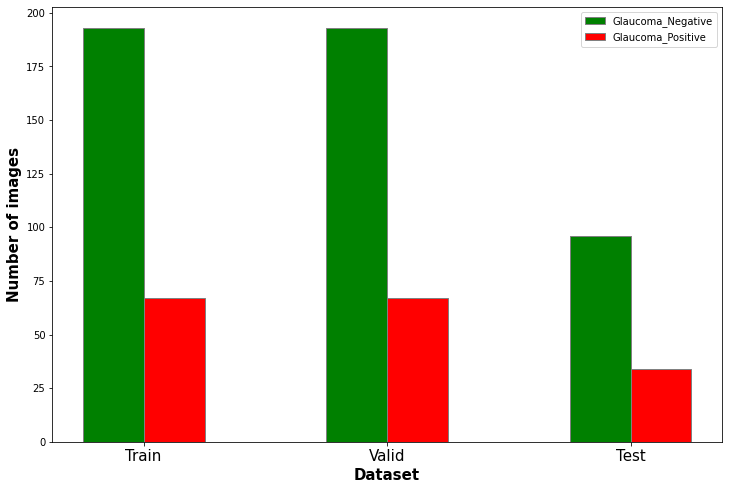

Ratio glaucoma_positive:glaucoma_negative for train_dataset: (1:2.88)


In [5]:
def getNumFilesFromFolder(folder_path):
    return  len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
glaucoma_neg_count = [
    getNumFilesFromFolder(train_path + folder_separator + classes[0]),
    getNumFilesFromFolder(valid_path + folder_separator + classes[0]),
    getNumFilesFromFolder(test_path + folder_separator + classes[0])]
glaucoma_pos_count = [
    getNumFilesFromFolder(train_path + folder_separator + classes[1]),
    getNumFilesFromFolder(valid_path + folder_separator + classes[1]),
    getNumFilesFromFolder(test_path + folder_separator + classes[1])]

# Set position of bar on X axis
br1 = np.arange(len(glaucoma_neg_count))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, glaucoma_neg_count, color ='g', width = barWidth,
        edgecolor ='grey', label =classes[0])
plt.bar(br2, glaucoma_pos_count, color ='r', width = barWidth,
        edgecolor ='grey', label =classes[1])

# Adding Xticks
plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of images', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(glaucoma_neg_count))],
    ['Train', 'Valid', 'Test'], fontsize=15)

plt.legend()
plt.show()

train_glaucoma_neg_count = getNumFilesFromFolder(train_path + folder_separator + classes[0])
train_glaucoma_pos_count = getNumFilesFromFolder(train_path + folder_separator + classes[1])
train_glaucoma_ratio = round(train_glaucoma_neg_count / train_glaucoma_pos_count, 2)

print(f"Ratio glaucoma_positive:glaucoma_negative for train_dataset: (1:{train_glaucoma_ratio})")


## Augment and balance data

In [6]:
# Generator for data augmentation
# Possible augmentations: rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True
data_aug_gen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.8, 1.2])

# Make dir for the glaucoma_positive augmentated train set
aug_positive_path = augmented_train_path+folder_separator+classes[1]
if os.path.isdir(aug_positive_path) is True:
    shutil.rmtree(aug_positive_path)
os.makedirs(aug_positive_path)

batch_size=1
# Get batches for images from glaucoma_positive train set and set save folder
aug_train_pos_batches =  data_aug_gen.flow_from_directory(directory=train_path, classes=[classes[1]], batch_size=batch_size, 
                            seed=42, save_to_dir=aug_positive_path, save_prefix='aug-image-', save_format='jpg')

# Generate as much augmented data as there is in the other class
for _ in range(int(train_glaucoma_neg_count/batch_size)):
    next(aug_train_pos_batches)

if os.path.isdir(augmented_train_path+folder_separator+classes[0]) is True:
    shutil.rmtree(augmented_train_path+folder_separator+classes[0])
os.makedirs(augmented_train_path+folder_separator+classes[0])

# Copy glaucoma_negative folder to augmented_data to pass it to ImageDataGenerator
temp = copy_tree(train_path+folder_separator+classes[0], augmented_train_path+folder_separator+classes[0])

# Set train path to new augmented train path
train_path=augmented_train_path

Found 67 images belonging to 1 classes.


## Visualize batch of images with data augmentation



GLAUCOMA_NEGATIVE (ORIGINAL + 4 AUGMENTATIONS)


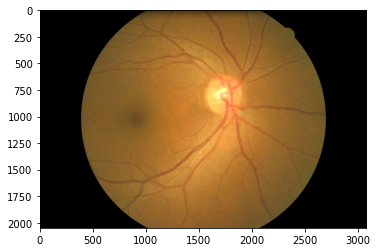

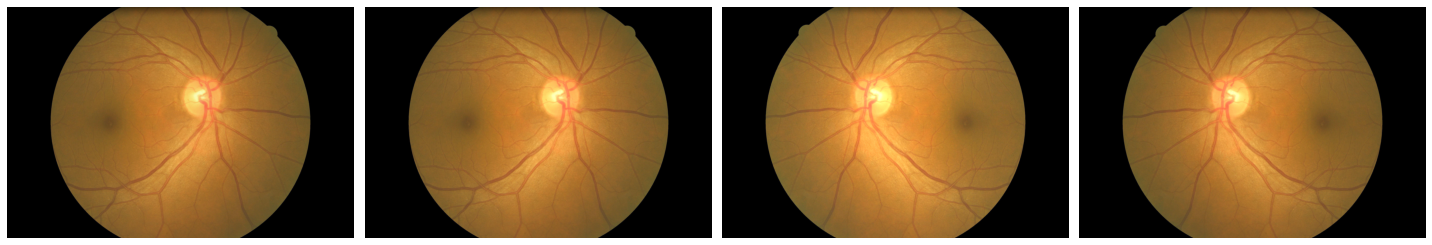

GLAUCOMA_POSITIVE (ORIGINAL + 4 AUGMENTATIONS)


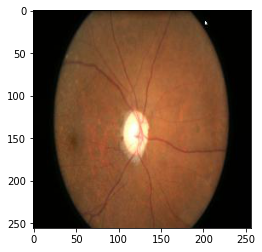

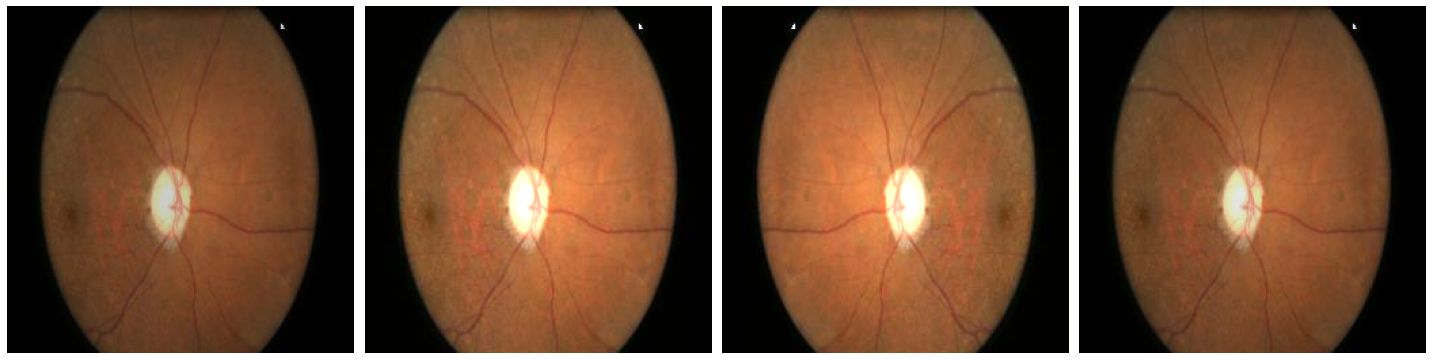

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def getRandomImageFromClass(choosen_class):
    chosen_image = random.choice(os.listdir(f'{train_path}{folder_separator}{choosen_class}'))
    image_path = f'{train_path}{folder_separator}{choosen_class}{folder_separator}{chosen_image}'
        
    image = np.expand_dims(plt.imread(image_path),0)
    return image


# Show full image and its data augmentation
print(classes[0].upper() + " (ORIGINAL + 4 AUGMENTATIONS)")
image = getRandomImageFromClass(classes[0])
plt.imshow(image[0])
aug_images = [next(data_aug_gen.flow(image))[0].astype(np.uint8) for i in range(4)]
plotImages(aug_images)

print(classes[1].upper() + " (ORIGINAL + 4 AUGMENTATIONS)")
image = getRandomImageFromClass(classes[1])
plt.imshow(image[0])
aug_images = [next(data_aug_gen.flow(image))[0].astype(np.uint8) for i in range(4)]
plotImages(aug_images)

## Show data distribution (after data augmentation)

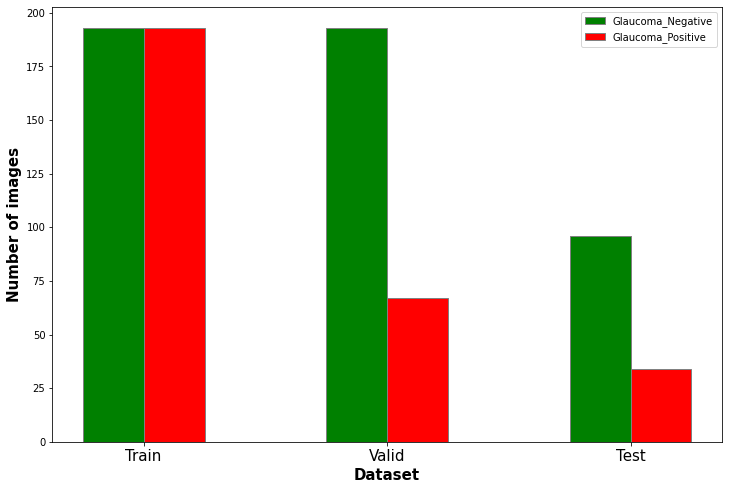

In [8]:
def getNumFilesFromFolder(folder_path):
    return  len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
glaucoma_neg_count = [
    getNumFilesFromFolder(augmented_train_path + folder_separator + classes[0]),
    getNumFilesFromFolder(valid_path + folder_separator + classes[0]),
    getNumFilesFromFolder(test_path + folder_separator + classes[0])]
glaucoma_pos_count = [
    getNumFilesFromFolder(augmented_train_path + folder_separator + classes[1]),
    getNumFilesFromFolder(valid_path + folder_separator + classes[1]),
    getNumFilesFromFolder(test_path + folder_separator + classes[1])]

# Set position of bar on X axis
br1 = np.arange(len(glaucoma_neg_count))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, glaucoma_neg_count, color ='g', width = barWidth,
        edgecolor ='grey', label =classes[0])
plt.bar(br2, glaucoma_pos_count, color ='r', width = barWidth,
        edgecolor ='grey', label =classes[1])

# Adding Xticks
plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of images', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(glaucoma_neg_count))],
    ['Train', 'Valid', 'Test'], fontsize=15)

plt.legend()
plt.show()


## Preprocess data

In [9]:
# Pick preprocessing generator
preprocessing_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
# preprocessing_generator = ImageDataGenerator(rescale=1./255)

def generate_image_generators():
    train_batches =  preprocessing_generator\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    valid_batches = preprocessing_generator\
        .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    test_batches = preprocessing_generator\
        .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False, seed=42)
    return train_batches, valid_batches, test_batches
train_batches, valid_batches, test_batches = generate_image_generators();

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


## Visualize batch of preprocessed images

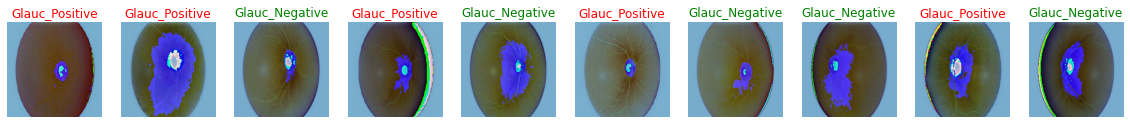

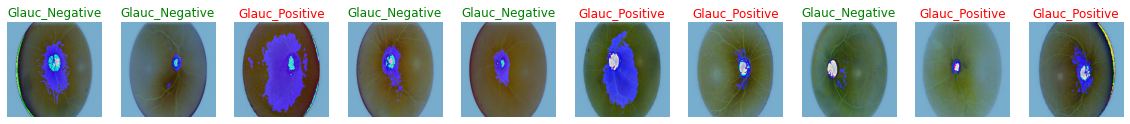

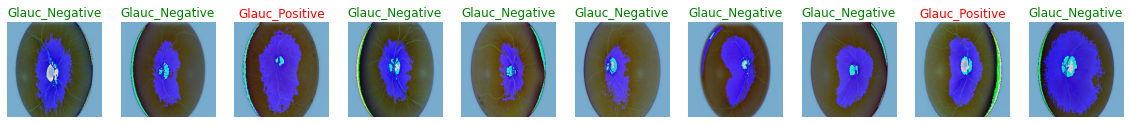

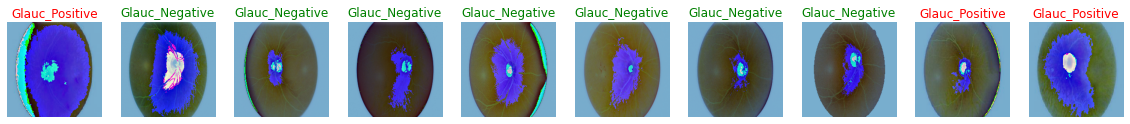

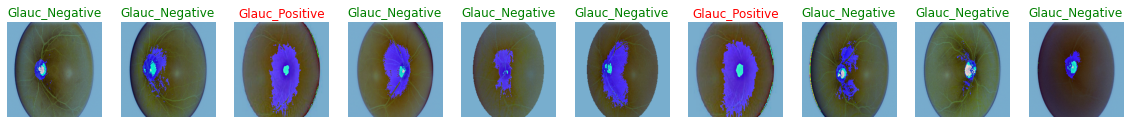

In [10]:
def numberLabelsToText(labels):
    return [classes[1] if str(label) == "[0. 1.]" else classes[0] for label in labels]

def shortenLabels(labels):
    return ["Glauc_"+classes[1].split("_")[1] if label == classes[1] else "Glauc_"+classes[0].split("_")[1] for label in labels]
    


def plotImagesWithLabels(imgs, labels):
    neg_pred_color = "green"
    pos_pred_color = "red"
    
    plt.figure(figsize=(20, 20))
    for i in range(len(imgs)):
        if labels[i] == shortenLabels(classes[0])[0]:
            color = neg_pred_color
        else:
            color = pos_pred_color
        plt.rcParams.update({'text.color': color})

        plt.subplot(1, len(imgs), i+1) # 1 row, x columns, Xst element
        plt.imshow((imgs[i] * 255).astype(np.uint8))
        plt.axis('off')
        plt.title(labels[i])
    plt.rcParams.update({'text.color': "black"})
    plt.show();

# Show preprocessed images
for i in range(5):
    imgs, labels = next(train_batches)   
    labels = numberLabelsToText(labels)
    labels = shortenLabels(labels)
    plotImagesWithLabels(imgs, labels)

## Build the model (Custom Model with Data Augmentation)

In [11]:
train_batches, valid_batches, test_batches = generate_image_generators();
custom_model = Sequential([
    # Data augmentation
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomContrast(factor=0.1),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


## Train the model  (Custom Model with Data Augmentation)

Epoch 1/20
39/39 - 90s - loss: 18.5289 - accuracy: 0.5699 - val_loss: 6.7708 - val_accuracy: 0.7385 - lr: 1.0000e-04 - 90s/epoch - 2s/step
Epoch 2/20
39/39 - 33s - loss: 3.3456 - accuracy: 0.6658 - val_loss: 2.1788 - val_accuracy: 0.6192 - lr: 1.0000e-04 - 33s/epoch - 836ms/step
Epoch 3/20
39/39 - 32s - loss: 1.1907 - accuracy: 0.7668 - val_loss: 2.0013 - val_accuracy: 0.7654 - lr: 1.0000e-04 - 32s/epoch - 830ms/step
Epoch 4/20
39/39 - 32s - loss: 0.4031 - accuracy: 0.9041 - val_loss: 1.4885 - val_accuracy: 0.7462 - lr: 1.0000e-04 - 32s/epoch - 833ms/step
Epoch 5/20
39/39 - 32s - loss: 0.1285 - accuracy: 0.9689 - val_loss: 1.8009 - val_accuracy: 0.7500 - lr: 1.0000e-04 - 32s/epoch - 832ms/step
Epoch 6/20
39/39 - 32s - loss: 0.0575 - accuracy: 0.9948 - val_loss: 1.2849 - val_accuracy: 0.7538 - lr: 1.0000e-04 - 32s/epoch - 831ms/step
Epoch 7/20
39/39 - 32s - loss: 0.0859 - accuracy: 0.9741 - val_loss: 2.0136 - val_accuracy: 0.7615 - lr: 1.0000e-04 - 32s/epoch - 831ms/step
Epoch 8/20
39/3

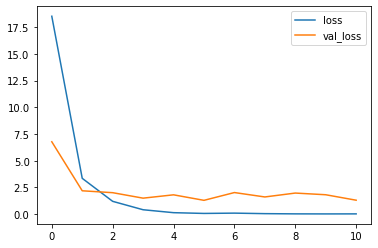

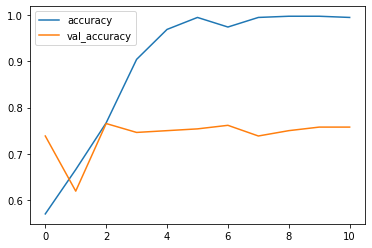

In [12]:
%%time
start_stopwatch = time.time()

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

history = custom_model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[early_stopping, lr_schedule],
    verbose=2
)
print(f"Model training time: {int(time.time()-start_stopwatch)} seconds")

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
model = custom_model

## Save model


In [13]:
# Uncomment to save the model
model_name =  'custom_model4' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models/custom_model4/assets


## Load model

In [14]:
# Uncomment to upload a pretrained model
model_name = 'custom_model2' # Set your model's folder name
model_path = models_path + model_name
model = keras.models.load_model(model_path)

## Make predictions

In [15]:
%%time
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 35 seconds
CPU times: user 9.84 s, sys: 147 ms, total: 9.99 s
Wall time: 35.6 s


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.80      0.79      0.80        96
Glaucoma_Positive       0.43      0.44      0.43        34

         accuracy                           0.70       130
        macro avg       0.61      0.62      0.62       130
     weighted avg       0.70      0.70      0.70       130



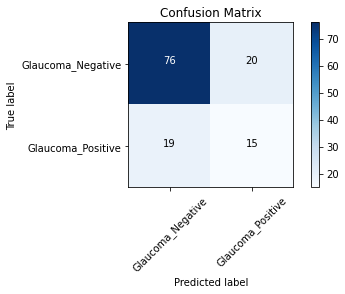

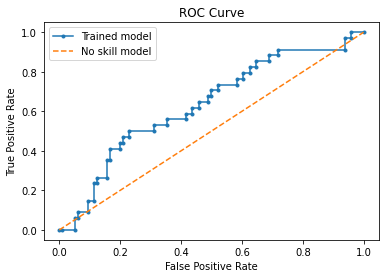

Trained model AUC: 0.634
No skill model AUC: 0.500


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          print_if_normalized=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if print_if_normalized: print("Normalized confusion matrix")
    else:
        if print_if_normalized: print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(fpr_1, tpr_1, title_1, fpr_2, tpr_2, title_2):
    # calculate roc curve
    plt.title('ROC Curve')
    plt.plot(fpr_1, tpr_1, marker='.', label=title_1)
    plt.plot(fpr_2, tpr_2, linestyle='--', label=title_2)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()


def evaluate_model():
    # Confusion Matrix
    cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
    plot_labels = classes
    plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix')
    
    # Classification report for precision, recall f1-score and accuracy
    report = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=plot_labels)
    print('Classification report : \n',report)
    plt.show()
    
    # ROC Curve and AUC
    y_true = test_batches.classes
    y_predicted_pos = predictions[:, 1]
    # ROC Curve
    tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_true, y_predicted_pos) # Trained model
    ns_probs = np.array([0 for _ in range(len(y_true))])
    ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true, ns_probs) # No skill model
    plot_roc_curve(tr_fpr, tr_tpr, "Trained model", ns_fpr, ns_tpr, "No skill model")
    # Auc
    roc_auc = roc_auc_score(y_true, y_predicted_pos) # Trained model
    print('Trained model AUC: %.3f' % roc_auc)
    roc_auc = roc_auc_score(y_true, ns_probs) # No skill model
    print('No skill model AUC: %.3f' % roc_auc)
    
evaluate_model()

## Precision-Recall Curve and Precision-Recall  AUC

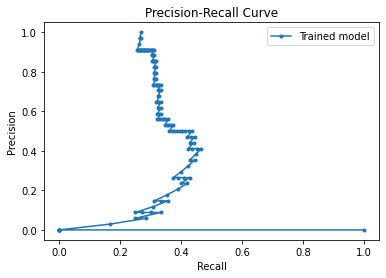

Trained model Precision-Recall AUC: 0.339


In [17]:
def plot_precision_recall_curve(precision, recall, no_skill):
    # plot the precision-recall curves
    # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.title('Precision-Recall Curve')
    plt.plot(precision, recall, marker='.', label="Trained model")
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

y_true = test_batches.classes
y_predicted_pos = predictions[:, 1]
# Precision-recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_predicted_pos)
no_skill = len(predictions[predictions==1]) / len(predictions)
plot_precision_recall_curve(precision, recall, no_skill)

# Precision-recall AUC
pres_recall_auc = auc(recall, precision)

print('Trained model Precision-Recall AUC: %.3f' % pres_recall_auc)

# Model interpretability with Lime

## Imports

In [18]:
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
%load_ext autoreload
%autoreload 2
import os,sys
from skimage.segmentation import mark_boundaries
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image


Notebook run using keras: 2.8.0


## Choose batch to analyze


<h4>LABELS (ACTUAL/PREDICTED):</h4>

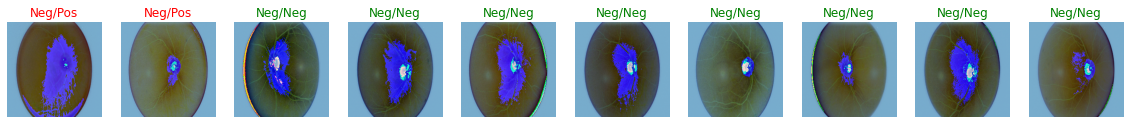

In [19]:
# Execute this cell until you find a batch you want to explain

def plotCompareLabels(imgs, labels):
    right_pred_color = "green"
    wrong_pred_color = "red"
    
    display(Markdown('<h4>{}</h4>'.format("LABELS (ACTUAL/PREDICTED):")))
    plt.figure(figsize=(20, 20))
    for i in range(len(imgs)):
        if labels[i].split("/")[0] == labels[i].split("/")[1]:
            color = right_pred_color
        else:
            color = wrong_pred_color
        
        plt.rcParams.update({'text.color': color})
        plt.subplot(1, len(imgs), i+1) # 1 row, x columns, Xst element
        plt.imshow((imgs[i] * 255).astype(np.uint8))
        plt.axis('off')
        plt.title(labels[i])        
    plt.rcParams.update({'text.color': "black"})
    plt.show();
    
def compareLabels(labels, predicted_labels):
    short_labels = [label.split("_")[1][:3] for label in labels]
    short_predicted_labels = [predicted_label.split("_")[1][:3] for predicted_label in predicted_labels]
    
    return [short_labels[i]+"/"+short_predicted_labels[i] for i in range(len(labels))]
            

# Get next batch of images from test set
imgs, labels = next(test_batches)

# Get predicted and actual values, and join in a string to compare
labels = numberLabelsToText(labels)
predicted_labels = numberLabelsToText(np.round(model.predict(imgs)))
compare_labels = compareLabels(labels, predicted_labels)

# Show comparation
plotCompareLabels(imgs, compare_labels)

## Calculate model explanations

In [20]:
%%time

explainer = lime_image.LimeImageExplainer()
# Get explanations
explanations = []
for img in imgs:
    # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanations.append(explainer.explain_instance(img.astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000))

# Plot explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 2min 13s, sys: 4.63 s, total: 2min 17s
Wall time: 2min 22s


## Visualize model explanations

<h3>FIRST HALF BATCH</h3>

<h4>LABELS (ACTUAL/PREDICTED):</h4>

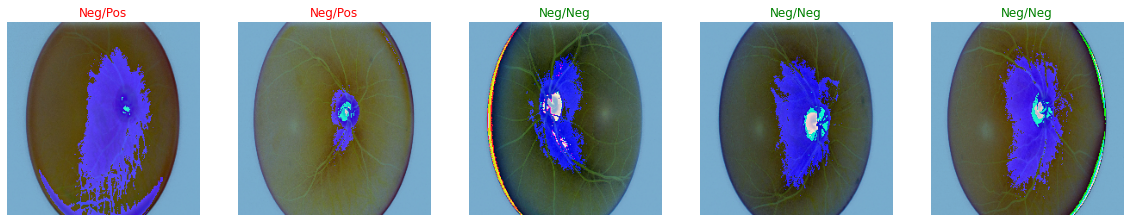

<h4>Top 5 superpixels that are most positive towards the class with the rest of the image hidden</h4>

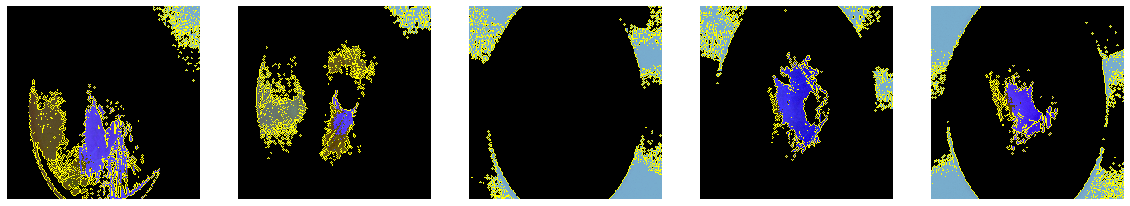

<h4>With the rest of the image present</h4>

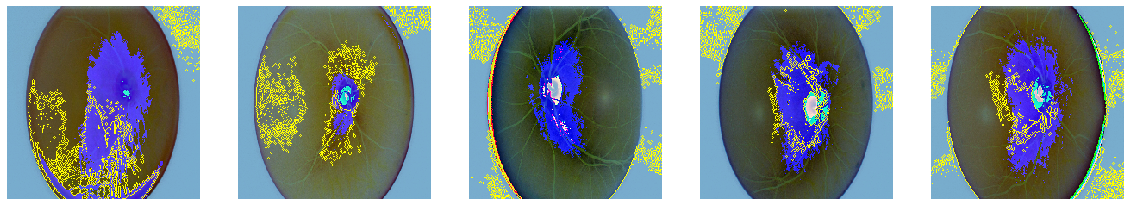

<h4>Pros and cons (pros in green, cons in red)</h4>

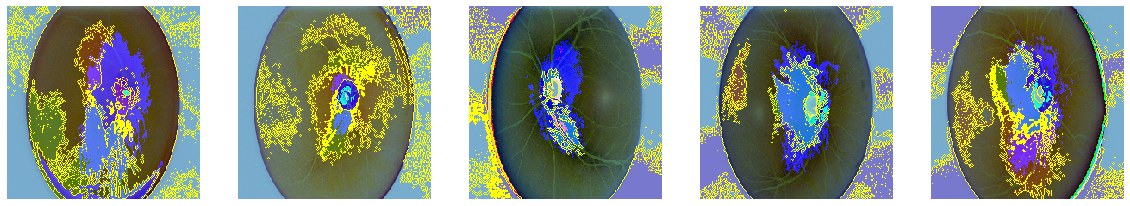

<h4>Pros and cons that have weight at least 0.1</h4>

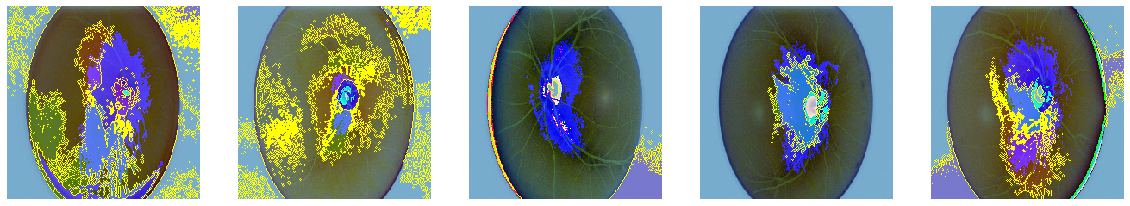

<h4>Explanation weights onto a heatmap visualization</h4>

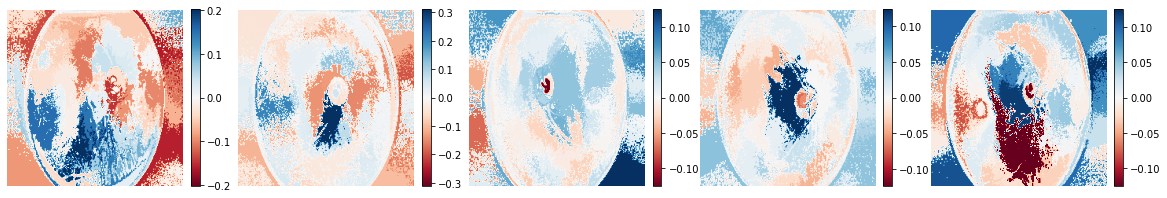

In [21]:
def plot_temps_masks(temps_masks, title, batch_size):
    plt.figure(figsize=(20, 20))
    display(Markdown('<h4>{}</h4>'.format(title)))
    for i in range(batch_size):    
        plt.subplot(1, batch_size, i+1) # 1 row, x columns, Xst element
        #plt.imshow(mark_boundaries(temps_masks[i][0], temps_masks[i][1]), interpolation='nearest')
        plt.imshow(mark_boundaries((temps_masks[i][0] * 255).astype(np.uint8), (temps_masks[i][1] * 255).astype(np.uint8)), interpolation='nearest')
        plt.axis('off')
    plt.show();


def plot_heatmaps(heatmaps, title, batch_size):
    plt.figure(figsize=(20, 20))
    display(Markdown('<h4>{}</h4>'.format(title)))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1) # 1 row, x columns, Xst element
        im = plt.imshow(heatmaps[i], cmap = 'RdBu', vmin  = -heatmaps[i].max(), vmax = heatmaps[i].max())
        plt.axis('off')
        plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.show();
    
def explain_batch(imgs, labels):
    labels = numberLabelsToText(labels)
    predicted_labels = numberLabelsToText(np.round(model.predict(imgs)))
    compare_labels = compareLabels(labels, predicted_labels)

    batch_size = len(imgs)
    plotCompareLabels(imgs, compare_labels)
    # Top 5 superpixels that are most positive towards the class with the rest of the image hidden
    temps_masks = []
    for i in range(batch_size):
        temps_masks.append(explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=True, num_features=5, hide_rest=True))
    plot_temps_masks(temps_masks, "Top 5 superpixels that are most positive towards the class with the rest of the image hidden", batch_size)

    # Same as above but with the rest of the image present
    temps_masks = []
    for i in range(batch_size):
        temps_masks.append(explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=True, num_features=5, hide_rest=False))
    plot_temps_masks(temps_masks, "With the rest of the image present", batch_size)

    # Pros and cons (pros in green, cons in red)
    temps_masks = []
    for i in range(batch_size):
        temps_masks.append(explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=False, num_features=10, hide_rest=False))
    plot_temps_masks(temps_masks, "Pros and cons (pros in green, cons in red)", batch_size)

    # Pros and cons that have weight at least 0.1
    temps_masks = []
    for i in range(batch_size):
        temps_masks.append(explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1))
    plot_temps_masks(temps_masks, "Pros and cons that have weight at least 0.1", batch_size)

    # Explanation weights onto a heatmap visualization
    heatmaps = []
    for i in range(batch_size):
        #Select the same class explained on the figures above.
        ind =  explanations[i].top_labels[0]
        #Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanations[i].local_exp[ind])
        heatmaps.append(np.vectorize(dict_heatmap.get)(explanations[i].segments))
    plot_heatmaps(heatmaps, "Explanation weights onto a heatmap visualization", batch_size)
    
    # Print again compare labels to easily constrast original images with last lime explanations
    compare_labels = compareLabels(labels, predicted_labels)

display(Markdown('<h3>{}</h3>'.format("FIRST HALF BATCH")))
explain_batch(imgs[:5], labels[:5])

<h3>SECOND HALF BATCH</h3>

<h4>LABELS (ACTUAL/PREDICTED):</h4>

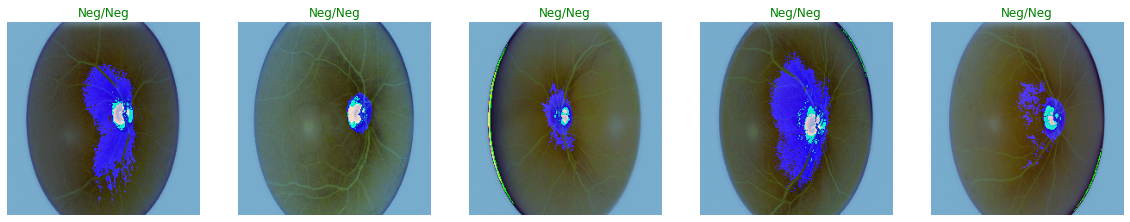

<h4>Top 5 superpixels that are most positive towards the class with the rest of the image hidden</h4>

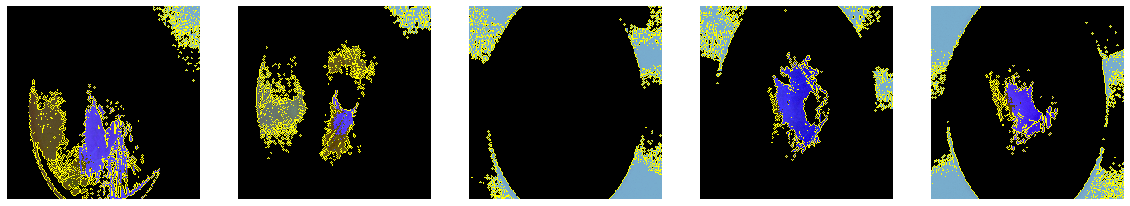

<h4>With the rest of the image present</h4>

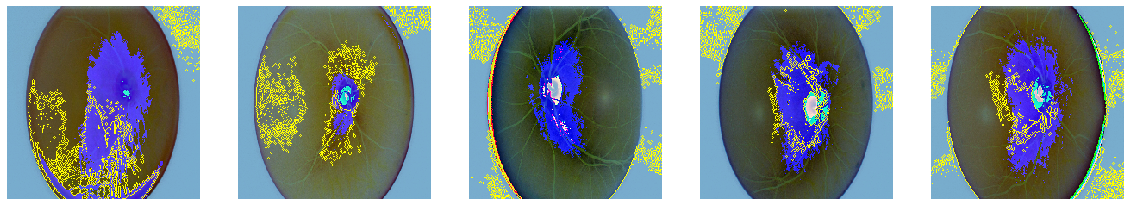

<h4>Pros and cons (pros in green, cons in red)</h4>

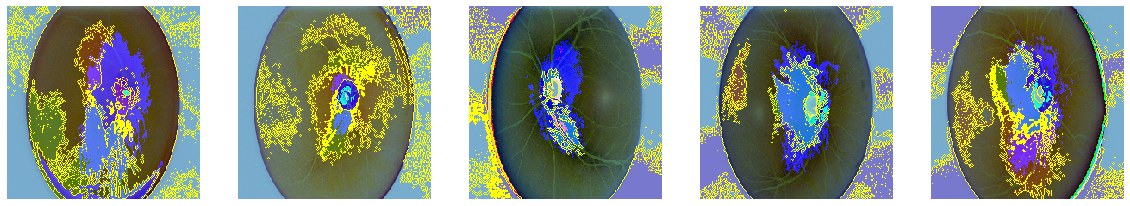

<h4>Pros and cons that have weight at least 0.1</h4>

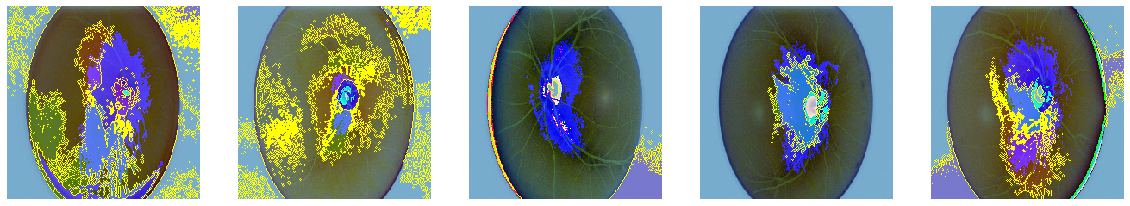

<h4>Explanation weights onto a heatmap visualization</h4>

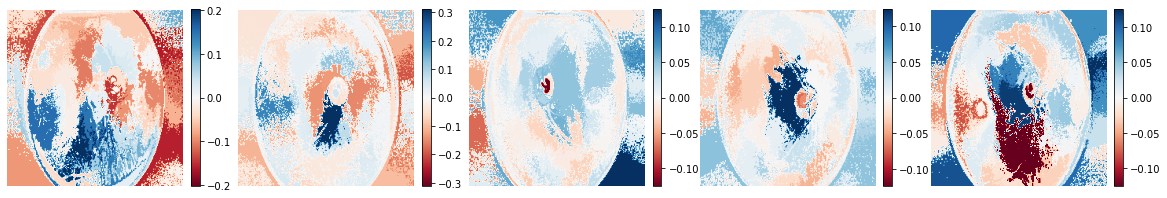

In [22]:
# Explain second half batch
display(Markdown('<h3>{}</h3>'.format("SECOND HALF BATCH")))
explain_batch(imgs[5:], labels[5:])

# Train model WITH ATTENTION

## Attention classes

In [23]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

## Model with more layers WITHOUT ATTENTION

In [24]:

simple_cnn_no_attention = Sequential([
    tf.keras.layers.Conv2D(32, 3,  input_shape=(224,224,3), activation='elu', padding='same'),   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=2, activation='softmax' )
])
simple_cnn_no_attention.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)
history = simple_cnn_no_attention.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[early_stopping, lr_schedule],
    verbose=2)
model= simple_cnn_no_attention

# Save model
model_name =  'model_without_attention' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

Epoch 1/20
39/39 - 36s - loss: 0.8125 - accuracy: 0.5984 - val_loss: 2.6106 - val_accuracy: 0.7385 - lr: 0.0010 - 36s/epoch - 922ms/step
Epoch 2/20
39/39 - 34s - loss: 0.4618 - accuracy: 0.7617 - val_loss: 3.6548 - val_accuracy: 0.7423 - lr: 0.0010 - 34s/epoch - 882ms/step
Epoch 3/20
39/39 - 33s - loss: 0.3520 - accuracy: 0.8472 - val_loss: 5.3718 - val_accuracy: 0.7423 - lr: 0.0010 - 33s/epoch - 850ms/step
Epoch 4/20
39/39 - 33s - loss: 0.2196 - accuracy: 0.9145 - val_loss: 3.5285 - val_accuracy: 0.7462 - lr: 0.0010 - 33s/epoch - 844ms/step
Epoch 5/20
39/39 - 33s - loss: 0.1898 - accuracy: 0.9430 - val_loss: 2.0657 - val_accuracy: 0.7500 - lr: 0.0010 - 33s/epoch - 845ms/step
Epoch 6/20
39/39 - 33s - loss: 0.2062 - accuracy: 0.9145 - val_loss: 2.4707 - val_accuracy: 0.7500 - lr: 0.0010 - 33s/epoch - 848ms/step
Epoch 7/20
39/39 - 33s - loss: 0.0943 - accuracy: 0.9560 - val_loss: 5.0135 - val_accuracy: 0.7423 - lr: 0.0010 - 33s/epoch - 841ms/step
Epoch 8/20
39/39 - 33s - loss: 0.2038 - a

## Make predictions

In [25]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 9 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.75      0.54      0.63        96
Glaucoma_Positive       0.28      0.50      0.36        34

         accuracy                           0.53       130
        macro avg       0.52      0.52      0.49       130
     weighted avg       0.63      0.53      0.56       130



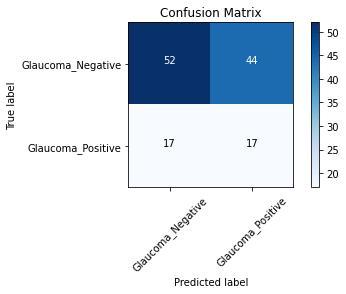

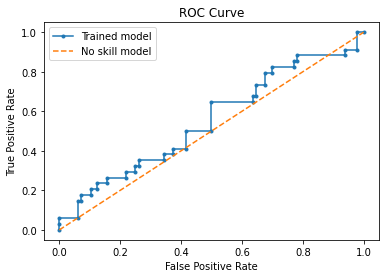

Trained model AUC: 0.551
No skill model AUC: 0.500


In [26]:
evaluate_model()

## Model with more layers WITH ATTENTION

In [27]:
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3,  input_shape=(224,224,3), activation='elu', padding='same'),   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=2, activation='softmax' )
])

simple_cnn_with_attention.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)
history = simple_cnn_with_attention.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[early_stopping, lr_schedule],
    verbose=2)
model= simple_cnn_with_attention

# Save model
model_name =  'model_with_attention' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

Epoch 1/20
39/39 - 34s - loss: 0.8275 - accuracy: 0.5803 - val_loss: 10.4031 - val_accuracy: 0.2577 - lr: 0.0010 - 34s/epoch - 882ms/step
Epoch 2/20
39/39 - 33s - loss: 0.3451 - accuracy: 0.8523 - val_loss: 1.5779 - val_accuracy: 0.6846 - lr: 0.0010 - 33s/epoch - 842ms/step
Epoch 3/20
39/39 - 33s - loss: 0.2841 - accuracy: 0.8990 - val_loss: 1.2124 - val_accuracy: 0.7000 - lr: 0.0010 - 33s/epoch - 841ms/step
Epoch 4/20
39/39 - 33s - loss: 0.2755 - accuracy: 0.8990 - val_loss: 1.9313 - val_accuracy: 0.7154 - lr: 0.0010 - 33s/epoch - 842ms/step
Epoch 5/20
39/39 - 34s - loss: 0.2667 - accuracy: 0.9041 - val_loss: 1.3038 - val_accuracy: 0.7462 - lr: 0.0010 - 34s/epoch - 874ms/step
Epoch 6/20
39/39 - 33s - loss: 0.1186 - accuracy: 0.9560 - val_loss: 3.4975 - val_accuracy: 0.7500 - lr: 0.0010 - 33s/epoch - 842ms/step
Epoch 7/20
39/39 - 33s - loss: 0.1174 - accuracy: 0.9508 - val_loss: 2.6395 - val_accuracy: 0.7500 - lr: 0.0010 - 33s/epoch - 847ms/step
Epoch 8/20
39/39 - 33s - loss: 0.1145 - 

## Make predictions

In [28]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 9 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.74      0.99      0.85        96
Glaucoma_Positive       0.50      0.03      0.06        34

         accuracy                           0.74       130
        macro avg       0.62      0.51      0.45       130
     weighted avg       0.68      0.74      0.64       130



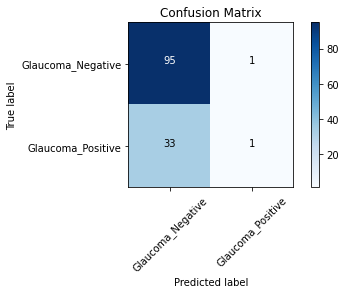

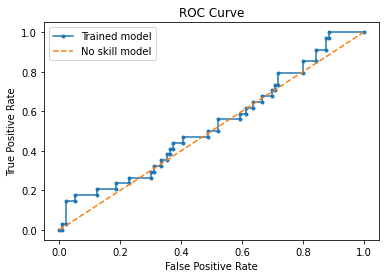

Trained model AUC: 0.531
No skill model AUC: 0.500


In [29]:
evaluate_model()

# Transfer learning - Feature Extraction

## Explore VGG16 layers


In [30]:
explore_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
print("Model number of layers: " + str(len(explore_model.layers)))
print(explore_model.summary())


553476096/553467096 [==============================] - 2s 0us/step
Model number of layers: 23
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                 

## Build and train VGG16

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
58900480/58889256 [==============================] - 0s 0us/step
Base model number of layers: 19
BASE MODEL SUMMARY:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                   

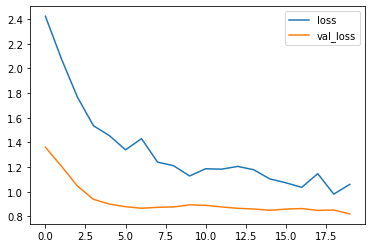

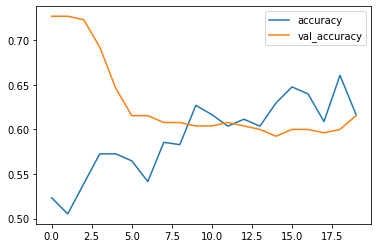

In [31]:
train_batches, valid_batches, test_batches = generate_image_generators();
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
print("Base model number of layers: " + str(len(base_model.layers)))
print("BASE MODEL SUMMARY:")
base_model.summary()


# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
    
    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax') # Softmax for binary class
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])


inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("Model number of layers: " + str(len(model.layers)))
print("MODEL SUMMARY:")
model.summary()


"""
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(inputs, training=False)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("MODEL SUMMARY:")
model.summary()
"""

"""
x = base_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x) # Softmax for binary class
model = keras.Model(inputs=base_model.input, outputs=x)
print("MODEL SUMMARY:")
model.summary()
"""

lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor='val_accuracy', mode='max', save_best_only=False, verbose= 1)

learning_rate= 5e-5
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[lr_reduce,checkpoint],
    verbose=2
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Save model
model_name =  'vgg16_feature_extraction' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

## Make predictions

In [32]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 10 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.81      0.76      0.78        96
Glaucoma_Positive       0.42      0.50      0.46        34

         accuracy                           0.69       130
        macro avg       0.62      0.63      0.62       130
     weighted avg       0.71      0.69      0.70       130



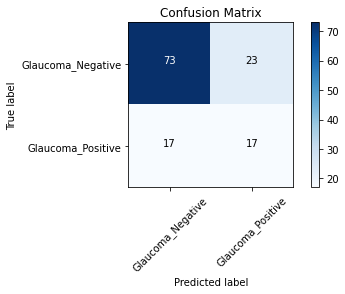

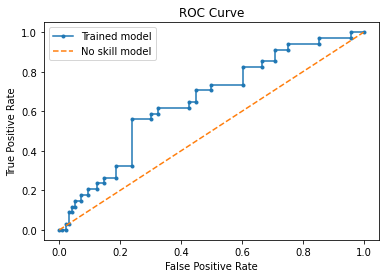

Trained model AUC: 0.653
No skill model AUC: 0.500


In [33]:
evaluate_model()

## Explore ResNet50 layers


In [34]:
explore_model =  tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Model number of layers: " + str(len(explore_model.layers)))
print(explore_model.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model number of layers: 175
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                

## Build and train ResNet50

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Base model number of layers: 175
BASE MODEL SUMMARY:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
              

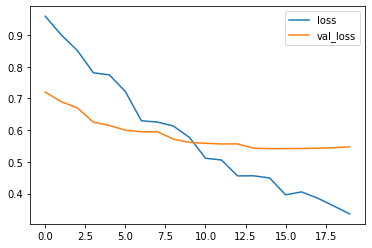

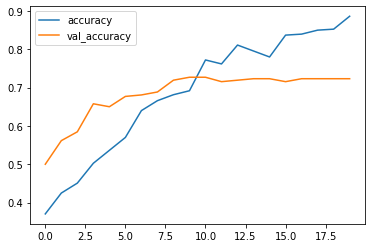

In [35]:
# Pick preprocessing generator
preprocessing_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

def generate_image_generators():
    train_batches =  preprocessing_generator\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    valid_batches = preprocessing_generator\
        .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    test_batches = preprocessing_generator\
        .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False, seed=42)
    return train_batches, valid_batches, test_batches
train_batches, valid_batches, test_batches = generate_image_generators();


# Build model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
print("Base model number of layers: " + str(len(base_model.layers)))
print("BASE MODEL SUMMARY:")
base_model.summary()


# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
    
    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax') # Softmax for binary class
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("Model number of layers: " + str(len(model.layers)))
print("MODEL SUMMARY:")
model.summary()


"""
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(base_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(2, activation='softmax'))
"""

# Train model
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=2e-5)
checkpoint = ModelCheckpoint(filepath='cifar10.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = False, verbose= 1)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics=["accuracy"])
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[lr_reduce,checkpoint],
    verbose=2
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Save model
model_name =  'resnet50_feature_extraction' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

## Make predictions

In [36]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 12 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.74      0.96      0.84        96
Glaucoma_Positive       0.33      0.06      0.10        34

         accuracy                           0.72       130
        macro avg       0.54      0.51      0.47       130
     weighted avg       0.64      0.72      0.64       130



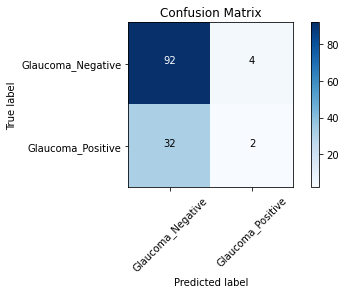

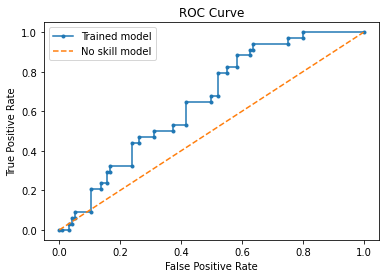

Trained model AUC: 0.652
No skill model AUC: 0.500


In [37]:
evaluate_model()

# Transfer learning - Fine-Tuning

## Explore VGG16 layers


In [38]:
explore_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
print("Model number of layers: " + str(len(explore_model.layers)))
print(explore_model.summary())


Model number of layers: 23
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None

## Build and train VGG16

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Base model number of layers: 19
BASE MODEL SUMMARY:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Con

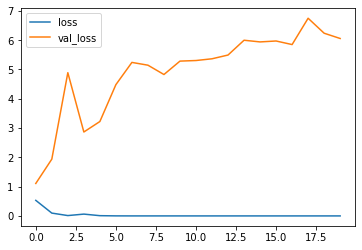

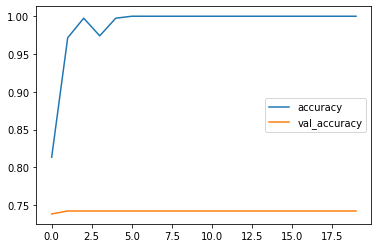

In [39]:
train_batches, valid_batches, test_batches = generate_image_generators();
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
print("Base model number of layers: " + str(len(base_model.layers)))
print("BASE MODEL SUMMARY:")
base_model.summary()

# Fine-tune from this layer onwards
fine_tune_at = 15
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
    
    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax') # Softmax for binary class
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])


inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("Model number of layers: " + str(len(model.layers)))
print("MODEL SUMMARY:")
model.summary()


"""
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(inputs, training=False)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("MODEL SUMMARY:")
model.summary()
"""

"""
x = base_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x) # Softmax for binary class
model = keras.Model(inputs=base_model.input, outputs=x)
print("MODEL SUMMARY:")
model.summary()
"""

learning_rate= 0.0001 # 5e-5 # 0.00005
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=learning_rate)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor='val_accuracy', mode='max', save_best_only=False, verbose= 1)

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[lr_reduce,checkpoint],
    verbose=2
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Save model
model_name =  'vgg16_fine_tuning' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

## Make predictions

In [40]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 10 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.74      1.00      0.85        96
Glaucoma_Positive       0.00      0.00      0.00        34

         accuracy                           0.74       130
        macro avg       0.37      0.50      0.42       130
     weighted avg       0.55      0.74      0.63       130



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


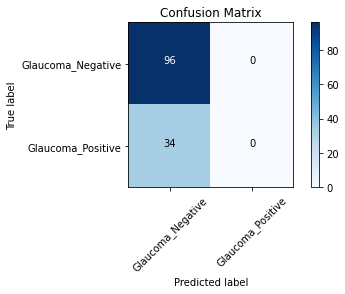

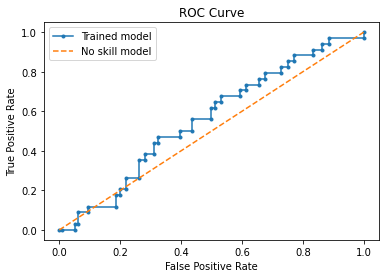

Trained model AUC: 0.559
No skill model AUC: 0.500


In [41]:
evaluate_model()

## Explore ResNet50 layers


In [42]:
explore_model =  tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Model number of layers: " + str(len(explore_model.layers)))
print(explore_model.summary())

Model number of layers: 175
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                               

## Build and train ResNet50

Found 386 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Base model number of layers: 175
BASE MODEL SUMMARY:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
              

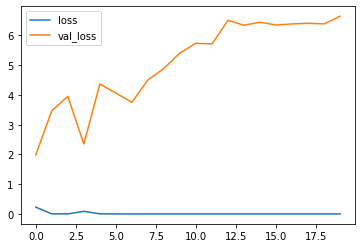

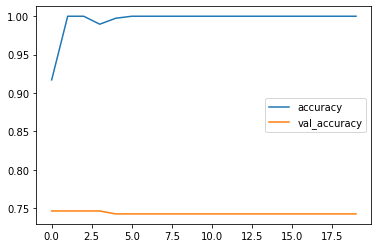

In [43]:
# Pick preprocessing generator
preprocessing_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

def generate_image_generators():
    train_batches =  preprocessing_generator\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    valid_batches = preprocessing_generator\
        .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=10, seed=42)
    test_batches = preprocessing_generator\
        .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False, seed=42)
    return train_batches, valid_batches, test_batches
train_batches, valid_batches, test_batches = generate_image_generators();


# Build model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
print("Base model number of layers: " + str(len(base_model.layers)))
print("BASE MODEL SUMMARY:")
base_model.summary()

# Fine-tune from this layer onwards
fine_tune_at = 143
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
    
    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax') # Softmax for binary class
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print("Model number of layers: " + str(len(model.layers)))
print("MODEL SUMMARY:")
model.summary()


"""
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(base_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(2, activation='softmax'))
"""

# Train model
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=2e-5)
checkpoint = ModelCheckpoint(filepath='cifar10.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = False, verbose= 1)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics=["accuracy"])
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=[lr_reduce,checkpoint],
    verbose=2
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Save model
model_name =  'resnet50_fine_tuning' # Set your model's folder name
model_path = models_path + model_name
model.save(model_path)

## Make predictions

In [44]:
start_stopwatch = time.time()
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
print(f"Model predicting time: {int(time.time()-start_stopwatch)} seconds")


Model predicting time: 11 seconds


## Evaluate the model

Classification report : 
                    precision    recall  f1-score   support

Glaucoma_Negative       0.74      1.00      0.85        96
Glaucoma_Positive       0.00      0.00      0.00        34

         accuracy                           0.74       130
        macro avg       0.37      0.50      0.42       130
     weighted avg       0.55      0.74      0.63       130



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


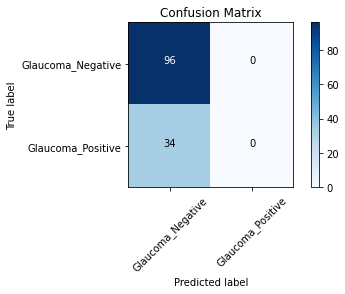

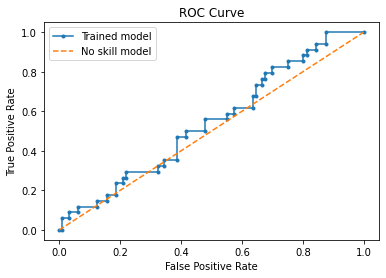

Trained model AUC: 0.545
No skill model AUC: 0.500


In [45]:
evaluate_model()